### 사전 준비

In [1]:
!pip install transformers==4.29 torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.4 MB/s eta 0:00:00


In [2]:
import json
import os
from PIL import Image
from torch import nn
import torch
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 모델 및 process 준비

In [4]:
from transformers import  AutoProcessor
from transformers import AutoModelForCausalLM, Swin2SRImageProcessor, BlipProcessor
import numpy as np
processor_git = AutoProcessor.from_pretrained('/content/drive/MyDrive/재원/model/caption/git/preprocessor')
model_git = torch.load('/content/drive/MyDrive/재원/model/caption/git/git_25000_all.pt')
processor_blip = BlipProcessor.from_pretrained('/content/drive/MyDrive/최종_BLIP_모델/preprocessor')
model_blip = torch.load('/content/drive/MyDrive/최종_BLIP_모델/blip_all_1e6_final.pt')
pro_sr = Swin2SRImageProcessor.from_pretrained('/content/drive/MyDrive/재원/eval/sr/preprocessor')
model_sr = torch.load('/content/drive/MyDrive/재원/eval/sr/swinsr.pt')

In [5]:
def image_with_sr(orgin): # 이미지 데이터 가져오기]
    image = super_reso(origin) if orgin.size[0]<50 or orgin.size[1]<100 else orgin
    return image

In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_sr.to(device)
def super_reso(image):
    inputs = pro_sr(image, return_tensors="pt").to(device)

    # forward pass
    with torch.no_grad():
        outputs = model_sr(**inputs)

    output = outputs.reconstruction.data.squeeze().cpu().float().clamp_(0, 1).numpy()
    output = np.moveaxis(output, source=0, destination=-1)
    output = (output * 255.0).round().astype(np.uint8)
    return Image.fromarray(output)

In [171]:
path = '/content/100.jpg'
origin = Image.open(path)
image1 = image_with_sr(origin)# 5000장에서 약 2분 소요

In [172]:
pixel_values =  processor_git.image_processor(images=image1, return_tensors="pt").pixel_values
model_git.to(device);
outputs_git=processor_git.batch_decode(model_git.generate(pixel_values=pixel_values.to(device),max_length = 300),skip_special_tokens=True)[0]

In [173]:
pixel_values =  processor_blip.image_processor(images=image1, return_tensors="pt").pixel_values
model_blip.to(device)
outputs_blip=processor_blip.batch_decode(model_blip.generate(pixel_values=pixel_values.to(device),max_length = 300),skip_special_tokens=True)[0]

In [174]:
print(outputs_git)
print(outputs_blip)

a grown woman is dressed in a black one - piece top and carrying a bag.
a senior woman is dressed in a black top with short sleeves, black pants that extend to her ankles, and carrying a bag.


### 그리기

In [175]:
import matplotlib.pyplot as plt

In [176]:
gt = "A senior woman is wearing black short shirt top and black long pants with a bag."

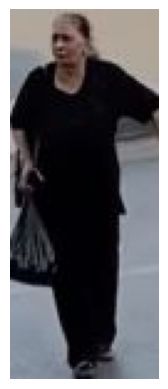

In [177]:
plt.imshow(image1)
#plt.text(-30, 114, str(image1.size), ha='left', va='top', fontsize=12, color='black')
#plt.text(-55,133,f'GT: {gt}',fontsize=10,color='black')
plt.axis('off')
#plt.text(-55,143,f'{name}: {outputs_git.split(",")[0]},', fontsize=10,color='black')
#plt.text(-45,153,f'{",".join(outputs_git.split(",")[1:])},', fontsize=10,color='black')
plt.show();

In [178]:
print("GT:",gt)
print("GIT:",outputs_git)
print("BLIP:",outputs_blip)

GT: A senior woman is wearing black short shirt top and black long pants with a bag.
GIT: a grown woman is dressed in a black one - piece top and carrying a bag.
BLIP: a senior woman is dressed in a black top with short sleeves, black pants that extend to her ankles, and carrying a bag.
